#### Centro de Operaciones Integradas

#### Planeación e Inteligencia de Negocios
# Predicción de Turbidez Meladura Evaporada 2021
### Ingenio Pánuco


Conjunto 2 datasets:
- Historicos 20-21.csv, con hipótesis de variables predictoras (Sistema de Control).
- Turbidez_Evap_21.csv, con información temporal de la variable dependiente Turbidez Meladura Evaporada (Target).

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, tree, svm, metrics
from sklearn.metrics import accuracy_score,explained_variance_score,mean_squared_error,r2_score,median_absolute_error
from matplotlib import pyplot
from IPython.display import Image
from sklearn.metrics import plot_confusion_matrix

# from feature-engine
from feature_engine import missing_data_imputers as mdi

import os

## Hipótesis - Variables Predictoras
Se realiza una carga del dataset, desde un archivo **.csv** original.
Este dataset contiene información de la zafra 20-21 de variables de proceso relacionadas con la clarificación de meladura.
La hipótesis es que variables de Flujo, Temperatura y pH del proceso de clarificación determinan el valor numérico de la Turbidez de la meladura, evaluada por Laboratorio.


### Data Cleaning
En esta etapa, se realiza un examen y limpieza del dataset, con el objetivo de prepararlo para los algoritmos de ML.

In [2]:
# Carga de Dataset (Xi)
Historicos_2021 = pd.read_csv('./Historicos 20-21.csv')

# La Estampa de Tiempo se transforma en tipo de Datetime
Historicos_2021['TimeStamp'] = pd.to_datetime(Historicos_2021['TimeStamp']).dt.date

# Las variables predictoras del archivo 'FT44120_Val','FT44102','FT44110_Val' carecen de información
Historicos_2021.drop(columns=['FT44120_Val','FT44102','FT44110_Val'],inplace=True)

# Las variables con baja calidad, marcadas por el sistema de control como 'Bad Input' son reemplazadas por NULL
Historicos_2021.replace('Bad Input',np.nan,inplace=True)

# El target a predecir es numérico, por lo que el problema es una optimización de tipo Regresión.
# Para este propósito, es necesario garantizar que todas las variables sean de tipo "numérico"
Historicos_2021["FT44101"] = pd.to_numeric(Historicos_2021["FT44101"])
Historicos_2021["TT44101"] = pd.to_numeric(Historicos_2021["TT44101"])
Historicos_2021["TT44102"] = pd.to_numeric(Historicos_2021["TT44102"])
Historicos_2021["FT44104"] = pd.to_numeric(Historicos_2021["FT44104"])
Historicos_2021["FT44204"] = pd.to_numeric(Historicos_2021["FT44204"])
Historicos_2021["FT44103"] = pd.to_numeric(Historicos_2021["FT44103"])
Historicos_2021["LT44103"] = pd.to_numeric(Historicos_2021["LT44103"])
Historicos_2021["AT44101"] = pd.to_numeric(Historicos_2021["AT44101"])
Historicos_2021["AT44102"] = pd.to_numeric(Historicos_2021["AT44102"])
Historicos_2021["FT44106_Val"] = pd.to_numeric(Historicos_2021["FT44106_Val"])

# Previsualización del Dataset
Historicos_2021.head()

,TimeStamp,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val
0,2020-11-14,104.518456,75.477295,85.790382,51.002132,0.008176,1.468404,32.031296,6.232646,6.232692,0.149869
1,2020-11-14,72.155151,81.717064,85.586281,34.761383,0.008819,1.459488,25.739313,6.199894,6.206853,0.151888
2,2020-11-14,76.439682,81.292473,85.024811,36.597282,0.009462,1.450571,27.747059,6.221014,6.227496,0.153906
3,2020-11-14,79.473289,81.774437,84.463341,41.406548,0.010105,1.441655,28.666933,6.499009,6.503285,0.155925
4,2020-11-14,79.668114,81.848770,84.531616,38.471184,0.010748,1.432738,29.055489,6.457737,6.471326,0.157943


### Imputación de Valores Faltantes
El dataset original puede carecer de valores (valores vacíos o valores identificados de baja calidad).
En la etapa anterior los valores de baja calidad se marcaron como NULL (faltantes), por lo que es necesario conocer la estadística de valores faltantes.

In [3]:
Historicos_2021.isnull().mean()

TimeStamp      0.000000
FT44101        0.000164
TT44101        0.009303
TT44102        0.000123
FT44104        0.000000
FT44204        0.009303
FT44103        0.000082
LT44103        0.000041
AT44101        0.000369
AT44102        0.000451
FT44106_Val    0.009631
dtype: float64

Existen valores faltantes en todas las variables (por ejemplo 'FT44106_Val' tiene un 0.96% de valores faltantes), a excepción de 'FT44104' y 'TimeStamp'.
Por ello es necesario "completar" estos valores. Dado que el porcentaje de valores faltantes es menor al 5%, puede realizarse una imputación por MEDIA (es decir, se hará un modelo que calcule la media aritmética de la variable específica, y se use esta media para llenar el valor faltante). Es posible hacer una imputación por MEDIANA, si asumimos que la distribución no es NORMAL, pero en este ejercicio, al ser muy bajos los valores faltantes y continuos, podemos asumir que las variables son normalmente distribuidas.

In [4]:
# Se construye el imputador con la Mediana
imputador_mediana = mdi.MeanMedianImputer(imputation_method='mean')

# Se entrena el imputador
imputador_mediana.fit(Historicos_2021)

# Se realiza la imputación
Historicos_2021 = imputador_mediana.transform(Historicos_2021)

Luego de realizada la imputación, se verifican que no existan más valores faltantes.

In [5]:
Historicos_2021.isnull().mean()

TimeStamp      0.0
FT44101        0.0
TT44101        0.0
TT44102        0.0
FT44104        0.0
FT44204        0.0
FT44103        0.0
LT44103        0.0
AT44101        0.0
AT44102        0.0
FT44106_Val    0.0
dtype: float64

### Variable Independiente Target
Se examina el valor de la variable independiente ***Yi: Turbidez de Meladura Evaporada***.
Se encuentra un conjunto de valores resultados de ensayos de Turbidez, organizados por Fecha y Lote (día de Zafra).
Los valores por día o por lote son variables, por lo que no hay relación 1 a 1 con el dataset de variables predictoras.
Es necesario establecer un criterio de agregación. Dado que el dataset de las **Yi** contiene información de la fecha del valor (por día), esta será la granularidad posible. El criterio de agregación será tomar la "media" por día (bajo la asunción de normalidad de las variables predictoras).

#### Medias por día
Se realiza una carga de las Yi's desde el archivo **.csv**, se transforma la información de fechas a tipo Datetime, se descarta el valor del Lote y se realiza un ordenamiento ascendente por fecha.




In [6]:
# Carga de Target (Yi)
Turbidez_Evap_21 = pd.read_csv('./Lab Evaporada 21.csv')
Turbidez_Evap_21['TimeStamp'] = pd.to_datetime(Turbidez_Evap_21['fecha_programada_muestreo'],dayfirst=True).dt.date
Turbidez_Evap_21.drop(columns=['id_lote'],inplace=True)
Y=pd.DataFrame(Turbidez_Evap_21.groupby(['TimeStamp']).mean())
Y.sort_values(by=['TimeStamp'],inplace=True, ascending=True)
Y.reset_index(inplace=True)
Y.head()

,TimeStamp,Turbidez Meladuras
0,2020-11-10,17496.79490
1,2020-11-11,11424.39065
2,2020-11-12,14793.03195
3,2020-11-13,11162.08702
4,2020-11-14,10715.11885


### Merge de Datasets
Establecido el campo para relacionar los datasets de predicción y de target, se realiza la "unión por fechas".
De acá, cada valor de las variables predictoras se relacionará con una media en ese día, a lo largo de la zafra.
Es posible hacer un refinamiento de este enfoque, calculando las medias de las variables predictoras por día. En este ejercicio dejaremos los distintos valores con el objetivo de evaluar una gran cantidad de datos y conservar la información de variabilidad.

In [7]:
# Relacionando Fecha
dataframe = pd.merge(Historicos_2021,  
                      Y,  
                      on ='TimeStamp',  
                      how ='inner')
dataframe

,TimeStamp,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val,Turbidez Meladuras
0,2020-11-14,104.518456,75.477295,85.790382,51.002132,0.008176,1.468404,32.031296,6.232646,6.232692,0.149869,10715.118850
1,2020-11-14,72.155151,81.717064,85.586281,34.761383,0.008819,1.459488,25.739313,6.199894,6.206853,0.151888,10715.118850
2,2020-11-14,76.439682,81.292473,85.024811,36.597282,0.009462,1.450571,27.747059,6.221014,6.227496,0.153906,10715.118850
3,2020-11-14,79.473289,81.774437,84.463341,41.406548,0.010105,1.441655,28.666933,6.499009,6.503285,0.155925,10715.118850
4,2020-11-14,79.668114,81.848770,84.531616,38.471184,0.010748,1.432738,29.055489,6.457737,6.471326,0.157943,10715.118850
...,...,...,...,...,...,...,...,...,...,...,...,...
17768,2021-02-18,75.023987,54.433968,85.105827,36.640205,0.000655,5.985616,34.173111,4.000000,4.002616,0.147064,5670.130867
17769,2021-02-18,74.817055,54.520721,84.669922,37.343769,0.000452,6.008565,34.271584,4.000000,4.002616,0.147281,5670.130867
17770,2021-02-18,74.470390,54.607471,81.769463,37.829521,0.000250,5.896521,34.043896,4.000000,4.002616,0.147499,5670.130867
17771,2021-02-18,74.123726,54.694225,84.957573,34.606472,0.000047,5.938420,34.375393,4.000000,4.002616,0.147716,5670.130867


### Algoritmos de ML
Este problema tiene un target numérico, y las variables de la hipótesis son todas numéricas, por lo que utilizaremos algoritmos de regresión para hacer la estimación.
Algunos de estos algoritmos son sensibles a la escala (valores muy grandes tienden a "pesar artificialmente más" en el modelo). Para eliminar este riesgo, se realiza una estandarización de las variables:
- Se calcula la Media y Desviación Estándar de cada variable.
- A cada valor se resta la Media, y esta diferencia se divide por su Desviación Estándar.

El resultado son valores en la misma escala [-1,1] para todas las variables

#### Estandarización

In [8]:
X = dataframe[dataframe.columns[1:11]].values
y = dataframe['Turbidez Meladuras'].values

scaler = StandardScaler()
Xstan = scaler.fit_transform(X)
dataStanX = pd.DataFrame(data = Xstan, columns = dataframe.columns[1:11])
dataStanX

,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val
0,1.888061,0.468187,1.048474,0.997007,-0.555090,-1.894462,0.029164,0.814933,0.713478,-0.352261
1,-0.815290,0.755153,1.033604,0.134822,-0.555062,-1.900445,-0.513550,0.770797,0.681446,-0.335055
2,-0.457397,0.735626,0.992697,0.232285,-0.555035,-1.906429,-0.340372,0.799259,0.707036,-0.317850
3,-0.203996,0.757792,0.951790,0.487599,-0.555008,-1.912412,-0.261029,1.173892,1.048938,-0.300644
4,-0.187722,0.761211,0.956764,0.331767,-0.554981,-1.918395,-0.227514,1.118273,1.009317,-0.283438
...,...,...,...,...,...,...,...,...,...,...
17768,-0.575652,-0.499595,0.998599,0.234564,-0.555406,1.136793,0.213906,-2.193837,-2.051189,-0.376176
17769,-0.592937,-0.495605,0.966841,0.271915,-0.555414,1.152193,0.222399,-2.193837,-2.051189,-0.374322
17770,-0.621895,-0.491615,0.755522,0.297702,-0.555423,1.077006,0.202760,-2.193837,-2.051189,-0.372468
17771,-0.650852,-0.487625,0.987798,0.126598,-0.555431,1.105123,0.231353,-2.193837,-2.051189,-0.370615


## Decision Tree Regressor
El primer algoritmo de regresión será un Árbol de Decisión.
Este algoritmo realiza particiones de las variables predictoras buscando la "menor entropía" en cada partición. El valor predicho por el regresor será la media de esta partición.
El parámetro importante es la profundidad máxima del árbol.

Se calcula la **Importancia de Factores**, que no es más que la variable que más importancia tuvo para la separación de particiones, y por lo tanto, para la estimación del valor target en las hojas.

Una vez estandarizado el Dataset, se incluyen los valores de la variable target **Turbidez**

In [9]:
dataStanDT = dataStanX.copy()
dataStanDT['Turbidez']=y
dataStanDT.head()

,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val,Turbidez
0,1.888061,0.468187,1.048474,0.997007,-0.555090,-1.894462,0.029164,0.814933,0.713478,-0.352261,10715.11885
1,-0.815290,0.755153,1.033604,0.134822,-0.555062,-1.900445,-0.513550,0.770797,0.681446,-0.335055,10715.11885
2,-0.457397,0.735626,0.992697,0.232285,-0.555035,-1.906429,-0.340372,0.799259,0.707036,-0.317850,10715.11885
3,-0.203996,0.757792,0.951790,0.487599,-0.555008,-1.912412,-0.261029,1.173892,1.048938,-0.300644,10715.11885
4,-0.187722,0.761211,0.956764,0.331767,-0.554981,-1.918395,-0.227514,1.118273,1.009317,-0.283438,10715.11885


Factor: 0 FT44101  Importancia:  0.054
Factor: 1 TT44101  Importancia:  0.216
Factor: 2 TT44102  Importancia:  0.064
Factor: 3 FT44104  Importancia:  0.028
Factor: 4 FT44204  Importancia:  0.082
Factor: 5 FT44103  Importancia:  0.282
Factor: 6 LT44103  Importancia:  0.059
Factor: 7 AT44101  Importancia:  0.011
Factor: 8 AT44102  Importancia:  0.101
Factor: 9 FT44106_Val  Importancia:  0.103


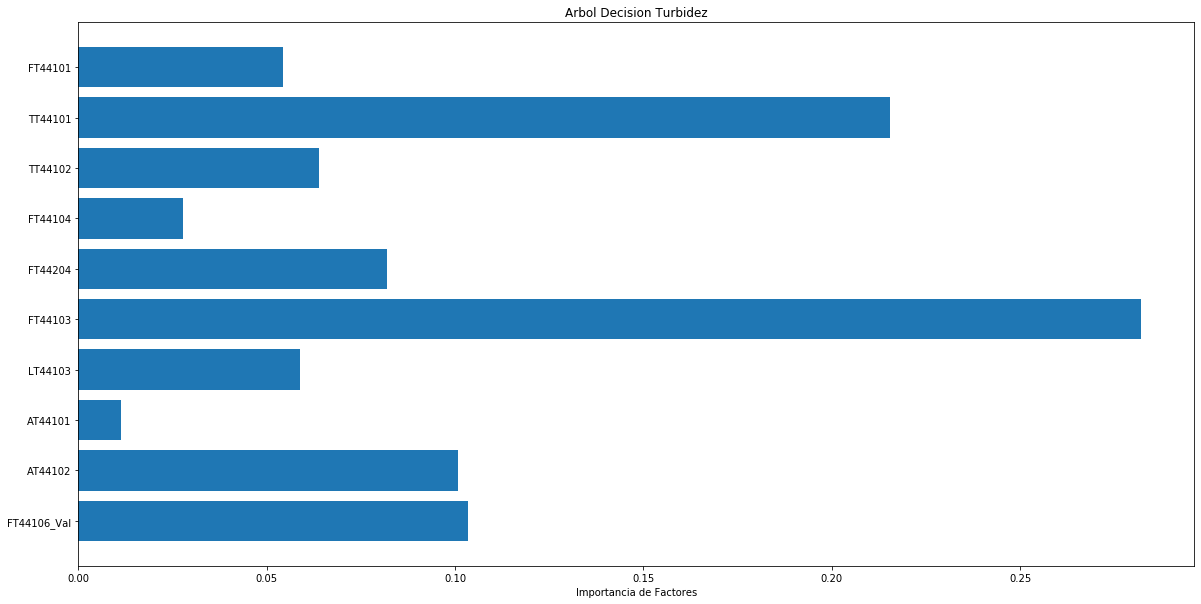

In [10]:
# Definición del modelo de Árbol de Decisión
modelo_ArbolDecision = DecisionTreeRegressor(max_depth = 15 )

# Entrenamiento del Modelo
modelo_ArbolDecision.fit(Xstan,y)

# Importancia de Factores para Decisiones en el Árbol
importancia = modelo_ArbolDecision.feature_importances_

for i,v in enumerate(importancia):
    print('Factor:',i, dataStanDT.columns[i],' Importancia: ',np.round(v,3))


# Semilla del estado Aleatorio (Reproducibilidad)
np.random.seed(19680801)

# Datos
variables = list(dataStanDT.columns)[:-1]
y_pos = np.arange(len(variables))
performance = importancia

fig, ax = plt.subplots(figsize=(20, 10))

hbars = ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importancia de Factores')
ax.set_title('Arbol Decision Turbidez')

plt.show()

#### Representación del Árbol

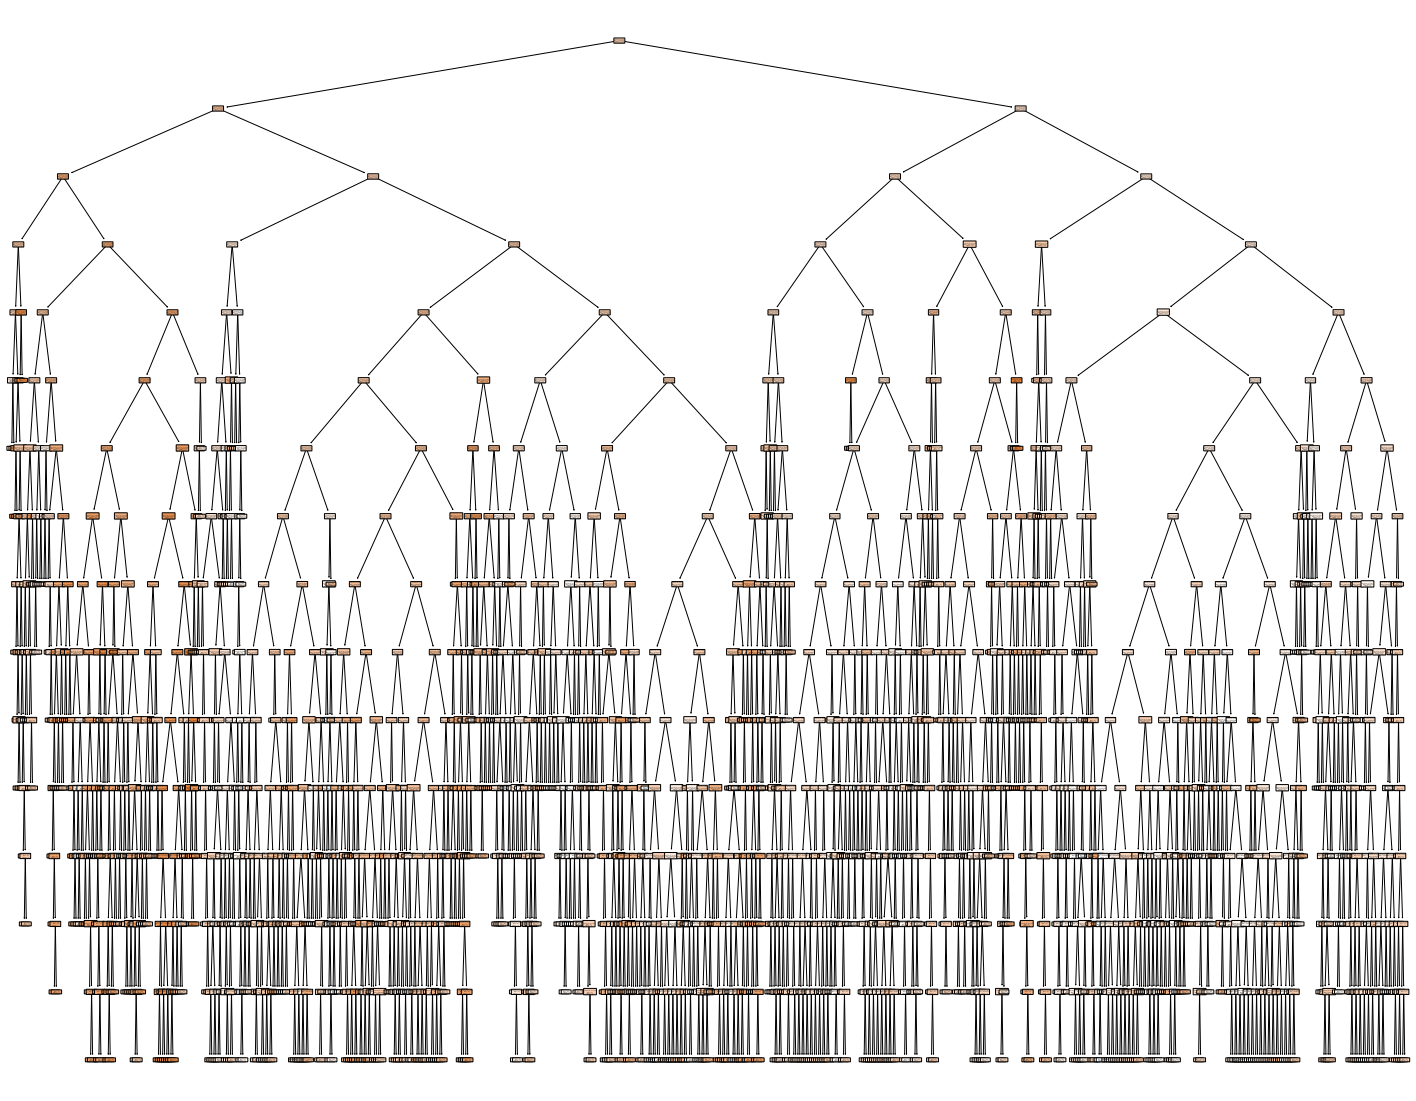

In [11]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelo_ArbolDecision, 
                   feature_names=dataStanX.columns,  
                   class_names=list(dataStanX.columns),
                   filled=True,
                   rounded=True)

#### Predicciones Arbol de Decisión
Una vez entrenado el modelo, se evalúa. En este caso, tomaremos el mismo dataset para verificar su desempeño. 

In [12]:
# Predicción de Turbidez
yhat = modelo_ArbolDecision.predict(dataStanX)

# Inclusión de valores de Predicción en Dataset
dataStanDT['Prediccion_Turbidez'] = yhat
dataStanDT.head()

,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val,Turbidez,Prediccion_Turbidez
0,1.888061,0.468187,1.048474,0.997007,-0.555090,-1.894462,0.029164,0.814933,0.713478,-0.352261,10715.11885,10715.11885
1,-0.815290,0.755153,1.033604,0.134822,-0.555062,-1.900445,-0.513550,0.770797,0.681446,-0.335055,10715.11885,8373.17789
2,-0.457397,0.735626,0.992697,0.232285,-0.555035,-1.906429,-0.340372,0.799259,0.707036,-0.317850,10715.11885,8373.17789
3,-0.203996,0.757792,0.951790,0.487599,-0.555008,-1.912412,-0.261029,1.173892,1.048938,-0.300644,10715.11885,8373.17789
4,-0.187722,0.761211,0.956764,0.331767,-0.554981,-1.918395,-0.227514,1.118273,1.009317,-0.283438,10715.11885,8373.17789


***Nivel de Explicación de Varianza del Modelo:***

In [13]:
explained_variance_score(dataStanDT['Turbidez'].values, dataStanDT['Prediccion_Turbidez'])

0.9922439382681401

***Error Cuadrático Medio:***

In [14]:
mean_squared_error(dataStanDT['Turbidez'].values, dataStanDT['Prediccion_Turbidez'])

50516.649845175954

***Coeficiente de Correlación (ponderado por varianza y promedio)***

In [15]:
r2_score(dataStanDT['Turbidez'].values, dataStanDT['Prediccion_Turbidez'],multioutput='variance_weighted')

0.9922439382681401

In [16]:
r2_score(dataStanDT['Turbidez'].values, dataStanDT['Prediccion_Turbidez'],multioutput='uniform_average')

0.9922439382681401

***Error Medio Absoluto***

In [17]:
median_absolute_error(dataStanDT['Turbidez'].values, dataStanDT['Prediccion_Turbidez'])


8.185452315956354e-12

#### Linealidad de las Predicciones
Se muestra la relación Predicción vrs. Valores Reales para la Turbidez de Meladura. En este caso se esperaría tener la mayoría de valores sobre una recta de pendiente **1**. Una regresión lineal sobre estos datos muestran efectivamente este comportamiento.

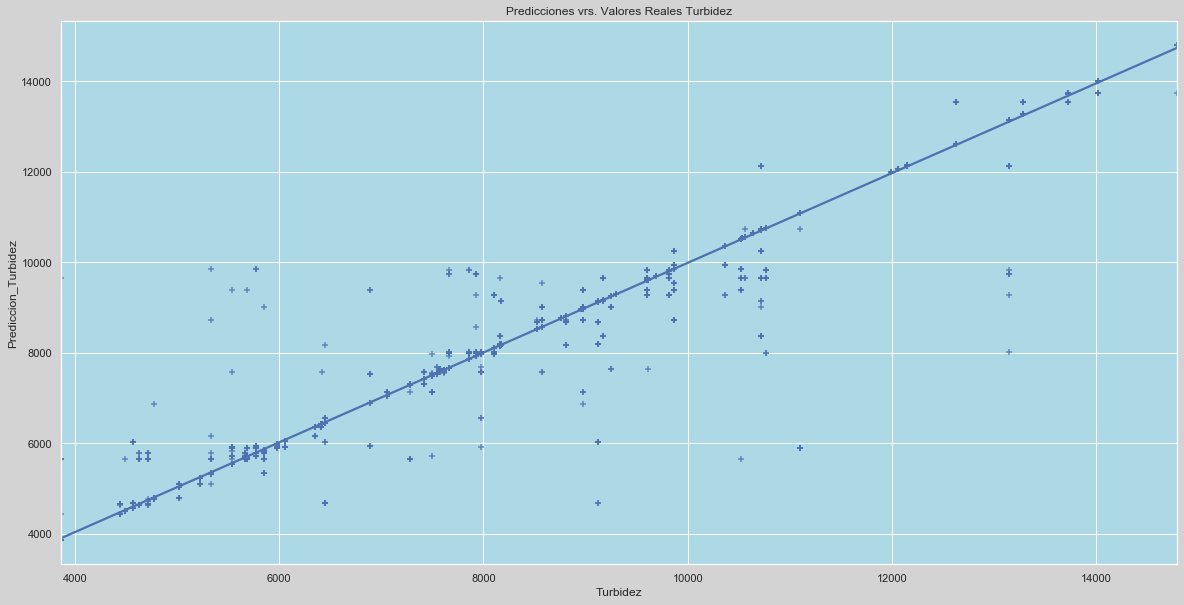

In [18]:
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgray'})

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.title("Predicciones vrs. Valores Reales Turbidez")
plt.xlabel('Turbidez Real')
plt.ylabel('Predicción Turbidez')

sns.regplot(x='Turbidez', y='Prediccion_Turbidez',data=dataStanDT,color="b",marker="+",ax=ax)

## Support Vector Machines Regressor
El segundo algoritmo de regresión será un Support Vector Machine.
Este algoritmo de clasificación busca una recta multidimensional que tiene el "mayor margen" entre posibles clases. En este caso continuo, busca un valor de predicción continuo.

In [19]:
dataStanSVM = dataStanX.copy()
dataStanSVM['Turbidez']=y
dataStanSVM.head()

,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val,Turbidez
0,1.888061,0.468187,1.048474,0.997007,-0.555090,-1.894462,0.029164,0.814933,0.713478,-0.352261,10715.11885
1,-0.815290,0.755153,1.033604,0.134822,-0.555062,-1.900445,-0.513550,0.770797,0.681446,-0.335055,10715.11885
2,-0.457397,0.735626,0.992697,0.232285,-0.555035,-1.906429,-0.340372,0.799259,0.707036,-0.317850,10715.11885
3,-0.203996,0.757792,0.951790,0.487599,-0.555008,-1.912412,-0.261029,1.173892,1.048938,-0.300644,10715.11885
4,-0.187722,0.761211,0.956764,0.331767,-0.554981,-1.918395,-0.227514,1.118273,1.009317,-0.283438,10715.11885


### Entrenamiento SVM

In [58]:
# Definición del modelo de Support Vector Machine
modelo_SVM = svm.SVR(C=300000,kernel='rbf')

# Entrenamiento del Modelo
modelo_SVM.fit(Xstan,y)

# Parámetros Entrenados
modelo_SVM.get_params()

{'C': 300000,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Predicción SVM

In [59]:
# Predicción de Turbidez
yhat = modelo_SVM.predict(dataStanX)

# Inclusión de valores de Predicción en Dataset
dataStanSVM['Prediccion_Turbidez'] = yhat
dataStanSVM.head()

,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val,Turbidez,Prediccion_Turbidez
0,1.888061,0.468187,1.048474,0.997007,-0.555090,-1.894462,0.029164,0.814933,0.713478,-0.352261,10715.11885,10715.490351
1,-0.815290,0.755153,1.033604,0.134822,-0.555062,-1.900445,-0.513550,0.770797,0.681446,-0.335055,10715.11885,10065.059784
2,-0.457397,0.735626,0.992697,0.232285,-0.555035,-1.906429,-0.340372,0.799259,0.707036,-0.317850,10715.11885,9430.297095
3,-0.203996,0.757792,0.951790,0.487599,-0.555008,-1.912412,-0.261029,1.173892,1.048938,-0.300644,10715.11885,9555.584234
4,-0.187722,0.761211,0.956764,0.331767,-0.554981,-1.918395,-0.227514,1.118273,1.009317,-0.283438,10715.11885,9434.001044


#### Desempeño Support Vector Machines

In [60]:
modelo_SVM.score(dataStanX, dataStanSVM['Turbidez'].values)

0.8978539065832102

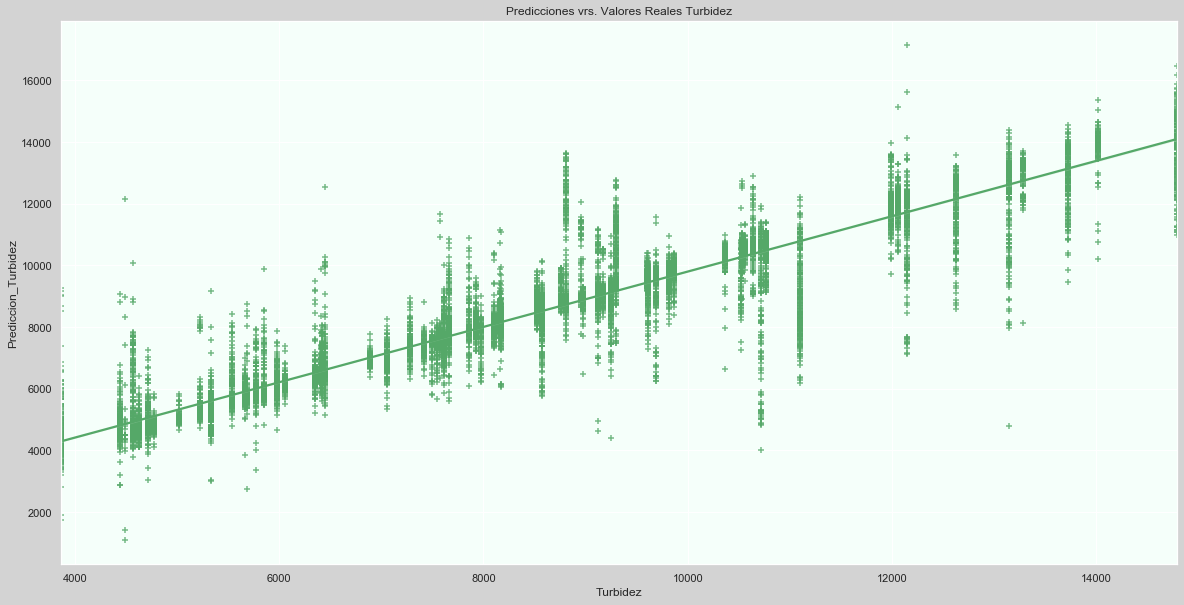

In [61]:
sns.set(rc={'axes.facecolor':'mintcream', 'figure.facecolor':'lightgray'})

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.title("Predicciones vrs. Valores Reales Turbidez")
plt.xlabel('Turbidez Real')
plt.ylabel('Predicción Turbidez')

sns.regplot(x='Turbidez', y='Prediccion_Turbidez',data=dataStanSVM,color="g",marker="+",ax=ax)

## Multilayer Perceptron Regressor (Red Neuronal)
El tercer algoritmo de regresión será un Perceptron Multicapa.
Este algoritmo combina varios modelos lineales de regresión con funciones de activación No lineales, permitiendo, según su profundidad, modelar relaciones no lineales complejas. En este caso se utilizará para aproximar un valor continuo (regresión) con una neurona de entrada para cada variable Xi.

In [32]:
dataStanMLP = dataStanX.copy()
dataStanMLP['Turbidez']=y
dataStanMLP.head()

,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val,Turbidez
0,1.888061,0.468187,1.048474,0.997007,-0.555090,-1.894462,0.029164,0.814933,0.713478,-0.352261,10715.11885
1,-0.815290,0.755153,1.033604,0.134822,-0.555062,-1.900445,-0.513550,0.770797,0.681446,-0.335055,10715.11885
2,-0.457397,0.735626,0.992697,0.232285,-0.555035,-1.906429,-0.340372,0.799259,0.707036,-0.317850,10715.11885
3,-0.203996,0.757792,0.951790,0.487599,-0.555008,-1.912412,-0.261029,1.173892,1.048938,-0.300644,10715.11885
4,-0.187722,0.761211,0.956764,0.331767,-0.554981,-1.918395,-0.227514,1.118273,1.009317,-0.283438,10715.11885


### Entrenamiento MLP

In [50]:
# Definición del modelo de Support Vector Machine
modelo_MLP = MLPRegressor(hidden_layer_sizes=(100,50,25,10),random_state=1, max_iter=500)

# Entrenamiento del Modelo
modelo_MLP.fit(Xstan,y)

# Parámetros Entrenados
modelo_MLP.get_params()

C:\ProgramData\Anaconda3\envs\datascience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100, 50, 25, 10),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

### Predicción Multilayer Perceptron

In [51]:
# Predicción de Turbidez
yhat = modelo_MLP.predict(dataStanX)

# Inclusión de valores de Predicción en Dataset
dataStanMLP['Prediccion_Turbidez'] = yhat
dataStanMLP.head()

,FT44101,TT44101,TT44102,FT44104,FT44204,FT44103,LT44103,AT44101,AT44102,FT44106_Val,Turbidez,Prediccion_Turbidez
0,1.888061,0.468187,1.048474,0.997007,-0.555090,-1.894462,0.029164,0.814933,0.713478,-0.352261,10715.11885,11783.288205
1,-0.815290,0.755153,1.033604,0.134822,-0.555062,-1.900445,-0.513550,0.770797,0.681446,-0.335055,10715.11885,8989.658728
2,-0.457397,0.735626,0.992697,0.232285,-0.555035,-1.906429,-0.340372,0.799259,0.707036,-0.317850,10715.11885,7405.864043
3,-0.203996,0.757792,0.951790,0.487599,-0.555008,-1.912412,-0.261029,1.173892,1.048938,-0.300644,10715.11885,8525.928173
4,-0.187722,0.761211,0.956764,0.331767,-0.554981,-1.918395,-0.227514,1.118273,1.009317,-0.283438,10715.11885,8682.645310


### Desempeño Multilayer Perceptron

In [52]:
modelo_MLP.score(dataStanX, dataStanSVM['Turbidez'].values)

0.9121009884481504

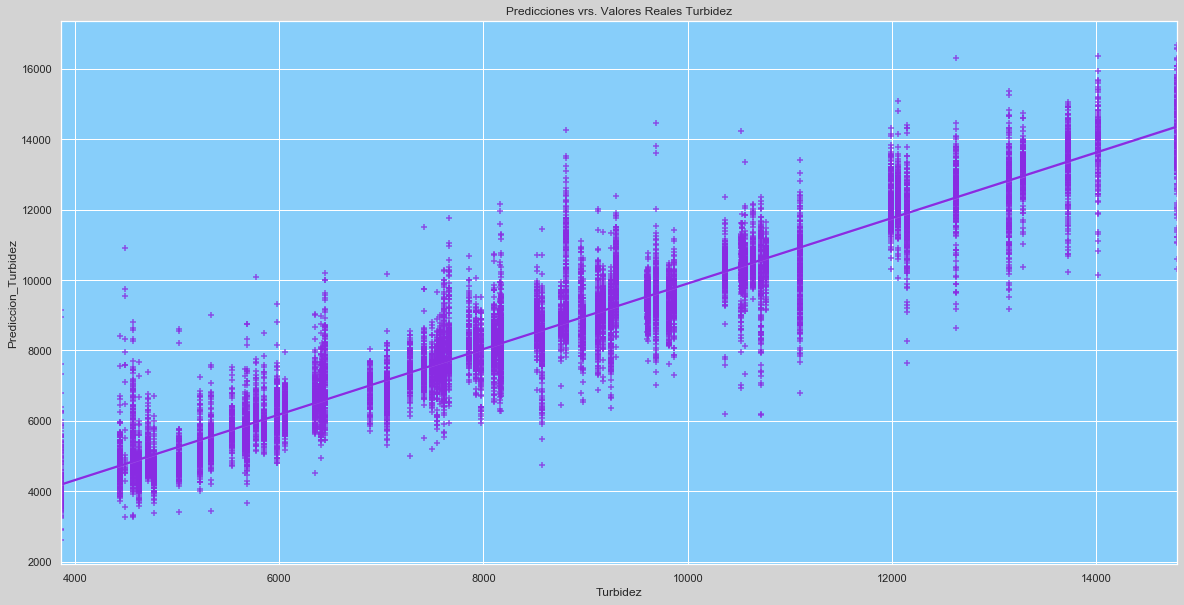

In [53]:
sns.set(rc={'axes.facecolor':'lightskyblue', 'figure.facecolor':'lightgray'})

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.title("Predicciones vrs. Valores Reales Turbidez")
plt.xlabel('Turbidez Real')
plt.ylabel('Predicción Turbidez')

sns.regplot(x='Turbidez', y='Prediccion_Turbidez',data=dataStanMLP,color="blueviolet",marker="+",ax=ax)